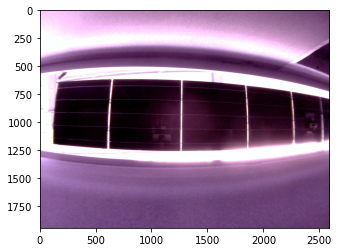

Original Dimensions :  (4192, 4192, 3)


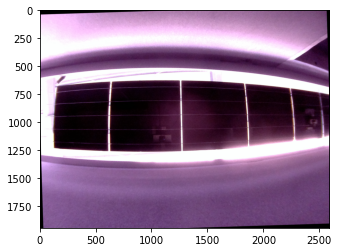

--- 1.0317120552062988 seconds for rotation ---


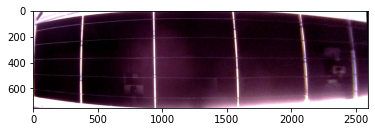

--- 2.2756989002227783 seconds for perspective---


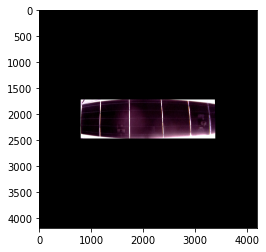

--- 4.480388164520264 seconds for perspective---


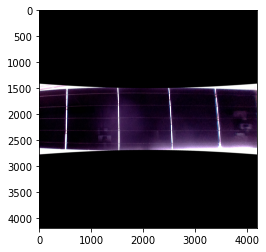

--- 17.21501111984253 seconds for fisheye---


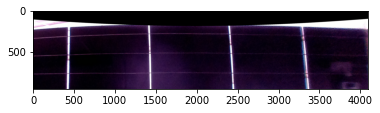

<Figure size 432x288 with 0 Axes>

In [35]:
from defisheye import Defisheye
import os
from PIL import Image
import cv2 
import numpy as np 
from matplotlib import pyplot as plt
import time

border = 800
def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGBA', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result
  
test_image = cv2.imread("testFisheye.png")
plt.imshow(test_image)
plt.show()

test_image = cv2.imread("testFisheye.png", cv2.IMREAD_UNCHANGED)
 
print('Original Dimensions : ',img.shape)
 
scale_percent = 60 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)



start_time = time.time()
result = rotate_image(test_image, 1.8)

plt.imshow(result)
plt.show()
print("--- %s seconds for rotation ---" % (time.time() - start_time))
cv2.imwrite("testFisheyeRotated.png", result)

# Locate points of the documents or object which you want to transform
pts1 = np.float32([[115, 580], [2592, 580], [115, 1320], [2592, 1320]])
pts2 = np.float32([[0, 0], [2592, -180], [0, 750], [2592, 960]])
  
# Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(pts1, pts2)

result = cv2.warpPerspective(result, matrix, (2592, 750))
plt.imshow(result)
plt.show()
cv2.imwrite("testFisheyeTransform.png", result)
print("--- %s seconds for perspective---" % (time.time() - start_time))

result = cv2.copyMakeBorder( result, 921+border, 921+border, border, border, cv2.BORDER_CONSTANT)
plt.imshow(result)
plt.show()
print("--- %s seconds for perspective---" % (time.time() - start_time))

cv2.imwrite("testFisheyeSquare.png", result)

img = "testFisheyeSquare.png"
img_out = "testFisheye_corrected.png"

dtype = 'linear'
format = 'fullframe'
fov = 179
pfov = 90
obj = Defisheye(img, dtype=dtype, format=format, fov=fov, pfov=pfov)
obj.convert(img_out)

import matplotlib.image as mpimg
img = mpimg.imread(img_out)
imgplot = plt.imshow(img)
plt.show()
print("--- %s seconds for fisheye---" % (time.time() - start_time))

crop_img = img[1321:2271, 100:4992]
imgplot = plt.imshow(crop_img)
plt.show()
plt.savefig('cropped.png')

In [7]:
# You should replace these 3 lines with the output in calibration step
from matplotlib import pyplot as plt
import cv2 
import numpy as np 
DIM=(2500, 1944)
K=np.array([[2500.3524863867165, 100.0, 2500.7118000552183], [00.0, 10000.5071163774452, 500.3314451453386], [0.0, 0.0, 1.0]])
D=np.array([[-0.042595202508066574], [0.031307765215775184], [-0.04104704724832258], [.115343014605793324]])
def undistort(img_path):
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    plt.imshow(undistorted_img)
    plt.show()
    
undistort("real1.jpeg")

KeyboardInterrupt: 

In [79]:
# import the necessary packages
import numpy as np
import cv2
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect

In [82]:
def gamma_trans(img, gamma):
    gamma_table=[np.power(x/255.0,gamma)*255.0 for x in range(256)]
    gamma_table=np.round(np.array(gamma_table)).astype(np.uint8)
    return cv2.LUT(img,gamma_table)

In [213]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = gamma_trans(image, 0.6)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    resized = cv2.resize(warped, (400,400), interpolation = cv2.INTER_AREA)
    resized_border = cv2.copyMakeBorder(resized,2,2,2,2,cv2.BORDER_CONSTANT, value = [255,255,255])
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(resized_border, -1, kernel)
    # return the warped image
    ret, thresh = cv2.threshold(im, 70, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for i, c in enumerate(contours):
        areaContour=cv2.contourArea(c)
        if areaContour<2000 or 20000<areaContour:
            continue
        #cv2.drawContours(im,contours,i,(255,255,255,100),2)
    return im

CMRmap


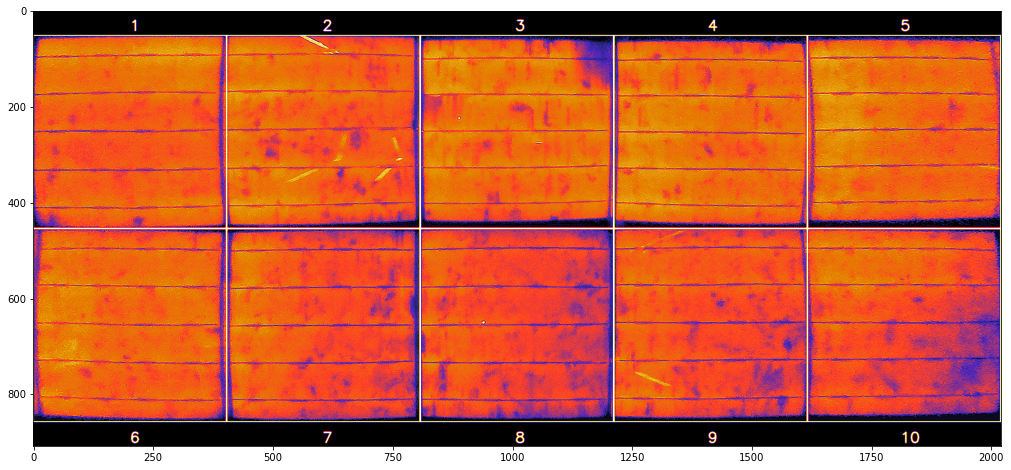

In [231]:
# import the necessary packages
#from pyimagesearch.transform import four_point_transform
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image
# construct the argument parse and parse the arguments
# load the image and grab the source coordinates (i.e. the list of
# of (x, y) points)
# NOTE: using the 'eval' function is bad form, but for this example
# let's just roll with it -- in future posts I'll show you how to
# automatically determine the coordinates without pre-supplying them
left_cells = cv2.imread("el2_image copy.png")
right_cells = cv2.imread("el1_image.png")
# define the points for the 5 left cells that will be shown on top
pts_top = []
pts_top.append(np.array([(40, 760), (470, 710), (500, 1320), (75, 1290)], dtype = "float32"))
pts_top.append(np.array([(470, 710), (1080, 660), (1100, 1340), (500, 1320)], dtype = "float32"))
pts_top.append(np.array([(1070, 650), (1720, 640), (1740, 1310), (1090, 1340)], dtype = "float32"))
pts_top.append(np.array([(1710, 640), (2210, 660), (2225, 1230), (1730, 1300)], dtype = "float32"))
pts_top.append(np.array([(2210, 670), (2530, 700), (2530, 1190), (2215, 1240)], dtype = "float32"))
# define the points for the right cells that will be shown on bottom
pts_bot = []
pts_bot.append(np.array([(40, 700), (440, 680), (420, 1240), (25, 1190)], dtype = "float32"))
pts_bot.append(np.array([(430, 680), (980, 685), (960, 1290), (410, 1240)], dtype = "float32"))
pts_bot.append(np.array([(980, 685), (1570, 710), (1560, 1300), (960, 1290)], dtype = "float32"))
pts_bot.append(np.array([(1570, 710), (2060, 750), (2040, 1280), (1560, 1300)], dtype = "float32"))
pts_bot.append(np.array([(2060, 750), (2390, 780), (2370, 1250), (2040, 1280)], dtype = "float32"))

# apply the four point tranform to obtain a "birds eye view" of
# the images
images_top = []
for x in pts_top:
    images_top.append(four_point_transform(left_cells, x))

images_bot = []
for x in pts_bot:
    images_bot.append(four_point_transform(right_cells, x))

#concat the images to a 2x5 matrix
im_h_top = cv2.hconcat(images_top)
im_h_bot = cv2.hconcat(images_bot)
combined = cv2.vconcat([im_h_top,im_h_bot])

#add a black border for text top and bottom
combined = cv2.copyMakeBorder(combined, 50, 50, 0, 0, cv2.BORDER_CONSTANT)
font = cv2.FONT_HERSHEY_SIMPLEX
for number in range(1,6):
    cv2.putText(combined, str(number), (-200+402*number,40), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
for number in range(6,11):
    cv2.putText(combined, str(number), (-200+402*(number-5),900), font,1, (255, 255, 255), 2, cv2.LINE_AA)

colors = ['CMRmap']
#colors = ['gray', 'Greys', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r']# , 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r',  'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']
for color in colors:
    print(color)
    plt.figure(figsize = (30,8))
    plt.imshow(combined, cmap=color),plt.show()

In [ ]:
import cv2;
import numpy as np;

# Run the code with the image name, keep pressing space bar

# Change the kernel, iterations, Contour Area, position accordingly
# These values work for your present image

img = cv2.imread("real1.jpeg", 0);
h, w = img.shape[:2]
kernel = np.ones((15,15),np.uint8)

e = cv2.erode(img,kernel,iterations = 2)  
d = cv2.dilate(e,kernel,iterations = 1)
ret, th = cv2.threshold(d, 150, 255, cv2.THRESH_BINARY_INV)

mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(th, mask, (200,200), 255); # position = (200,200)
out = cv2.bitwise_not(th)
out= cv2.dilate(out,kernel,iterations = 3)
cnt, h = cv2.findContours(out,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
for i in range(len(cnt)):
            area = cv2.contourArea(cnt[i])
            if(area>10000 and area<100000):
                  mask = np.zeros_like(img)
                  cv2.drawContours(mask, cnt, i, 255, -1)
                  x,y,w,h = cv2.boundingRect(cnt[i])
                  crop= img[ y:h+y,x:w+x]
                  cv2.imshow("snip",crop )
                  if(cv2.waitKey(0))==27:break

cv2.destroyAllWindows()

In [ ]:
from PIL import Image
import numpy as np

im = Image.open('image.png')
sqrWidth = np.ceil(np.sqrt(im.size[0]*im.size[1])).astype(int)
im_resize = im.resize((sqrWidth, sqrWidth))
im_resize.save('output.png')

In [26]:
import cv2

# read the image
image = cv2.imread('el1_image.png')
# convert the image to grayscale format
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

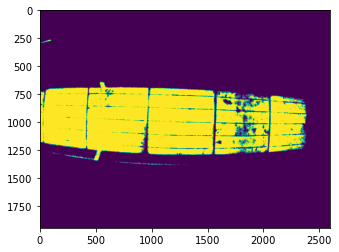

In [32]:
# apply binary thresholding
ret, thresh = cv2.threshold(img_gray, 50, 255, cv2.THRESH_BINARY)
# visualize the binary image
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(thresh)
plt.show()
#cv2.imshow('Binary image', thresh)
#cv2.waitKey(0)
#cv2.imwrite('image_thres1.jpg', thresh)

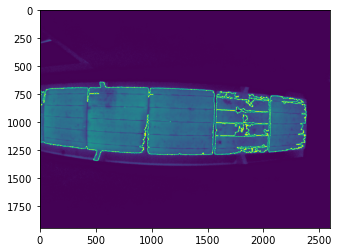

In [33]:
## DETERMINE CONTOURS AND FILTER THEM
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
 
#make a copy of the resized image since we are going to draw contours on the resized image
resizedImageCopy=np.copy(img_gray)
 
# draw all contours with setting the parameter to -1
# but if you use this function, you should comment the for loop below
#cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
#filter contours 
for i, c in enumerate(contours):
    areaContour=cv2.contourArea(c)
    if areaContour<20000 or 1000000<areaContour:
        continue
    cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)
     
# display the original image with contours

plt.imshow(resizedImageCopy)
plt.show()

In [236]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
 
# keep in mind that open CV loads images as BGR not RGB
image = cv2.imread("el2_image.png")
cv2.imshow('Image',image)
cv2.waitKey(0)
cv2.destroyAllWindows()
 
## RESIZE IMAGE
# scale in percentage
scale=60
newWidth = int(image.shape[1] * scale / 100)
newHeight = int(image.shape[0] * scale / 100)
newDimension = (newWidth, newHeight)
# resize image
resizedImage = cv2.resize(image, newDimension, interpolation = cv2.INTER_AREA)
cv2.imshow('Image',resizedImage)
cv2.waitKey(0)
cv2.destroyAllWindows()
# save the resized image
cv2.imwrite("resizedParts.png", resizedImage, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
## CONVERT TO GRAYSCALE
# convert image to grayscale
grayImage=cv2.cvtColor(resizedImage, cv2.COLOR_BGR2GRAY)
# display converted image
cv2.imshow('Image', grayImage)
cv2.waitKey(0)
cv2.destroyAllWindows()
# save the transformed image
cv2.imwrite("resizedPartsGray.png", grayImage, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 
# THRESHOLD 
# https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
#estimatedThreshold, thresholdImage=cv2.threshold(grayImage,50,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
estimatedThreshold, thresholdImage=cv2.threshold(grayImage,90,255,cv2.THRESH_BINARY)
# display converted image
cv2.imshow('Image', thresholdImage)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("resizedPartsThreshold.png", thresholdImage, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 


True

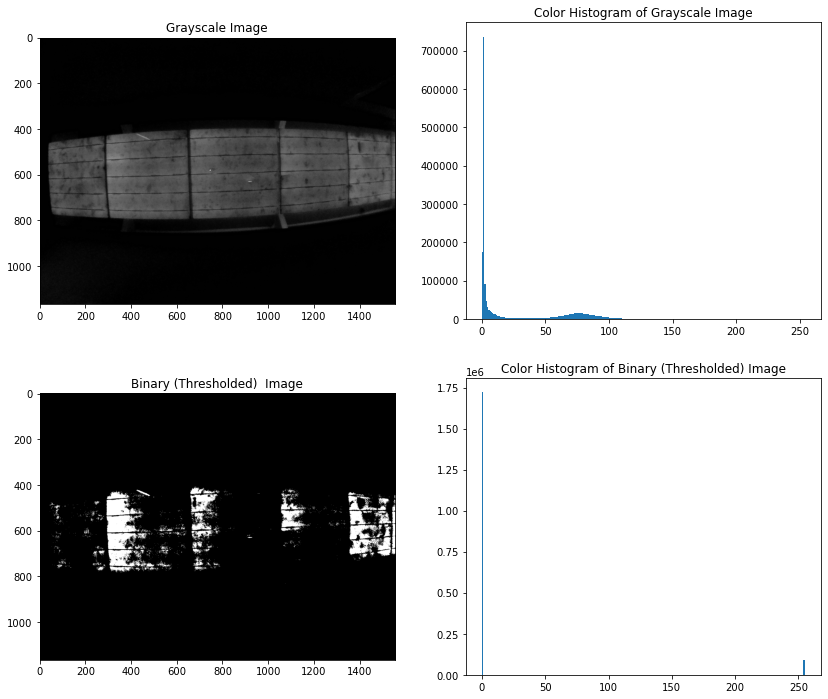

In [237]:
# PLOT HISTOGRAM OF THRESHOLDED AND GRAYSCALE IMAGES
plt.figure(figsize=(14, 12))
plt.subplot(2,2,1), plt.imshow(grayImage,'gray'), plt.title('Grayscale Image')
plt.subplot(2,2,2), plt.hist(grayImage.ravel(), 256), plt.title('Color Histogram of Grayscale Image')
plt.subplot(2,2,3), plt.imshow(thresholdImage,'gray'), plt.title('Binary (Thresholded)  Image')
plt.subplot(2,2,4), plt.hist(thresholdImage.ravel(),256), plt.title('Color Histogram of Binary (Thresholded) Image')
plt.savefig('fig1.png')
plt.show()

In [238]:
from matplotlib.pylab import cm
## DETERMINE CONTOURS AND FILTER THEM
contours, hierarchy = cv2.findContours(thresholdImage,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
 
#make a copy of the resized image since we are going to draw contours on the resized image
resizedImageCopy=np.copy(resizedImage)
 
# draw all contours with setting the parameter to -1
# but if you use this function, you should comment the for loop below
#cv2.drawContours(resizedImageCopy,contours,-1,(0,0,255),2)
#filter contours 
for i, c in enumerate(contours):
    areaContour=cv2.contourArea(c)
    if areaContour<2000 or 100000<areaContour:
        continue
    cv2.drawContours(resizedImageCopy,contours,i,(255,10,255),4)
     
# display the original image with contours
cv2.imshow('Image', resizedImageCopy)
cv2.waitKey(0)
cv2.destroyAllWindows()
colorized = cm.CMRmap(resizedImageCopy)
cv2.imwrite("resizedPartsContours.png", colorized*255, [cv2.IMWRITE_PNG_COMPRESSION, 0])
#cv2.imwrite("resizedPartsContours.png", resizedImageCopy, [cv2.IMWRITE_PNG_COMPRESSION, 0]) 

libpng warning: Invalid image width in IHDR
libpng warning: Image width exceeds user limit in IHDR
libpng warning: Invalid image height in IHDR
libpng warning: Image height exceeds user limit in IHDR
libpng error: Invalid IHDR data


False

In [241]:
import cv2
from matplotlib.pylab import cm

def colorize(image, colormap):
    im = cv2.imread(image)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    colorized = colormap(im)
    cv2.imshow("colorized", colorized)
    cv2.waitKey(0)
    cv2.imwrite("colorized.jpg", colorized*255)


colorize("el2_image.png", cm.CMRmap)

In [37]:
import cv2
import numpy as np

importedImage = 'el1_image.png'
originalImg = cv2.imread(importedImage)

#filters image bilaterally and displays it
bilatImg = cv2.bilateralFilter(originalImg, 5, 175, 175)

#finds edges of bilaterally filtered image and displays it
edgeImg = cv2.Canny(bilatImg, 75, 200)

#gets contours (outlines) for shapes and sorts from largest area to smallest area
contours, hierarchy = cv2.findContours(edgeImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# drawing red contours on the image
for con in contours:
    cv2.drawContours(originalImg, con, -1, (0, 0, 255), 3)

# and double-checking the outcome
cv2.imshow("Contours check",originalImg)
cv2.waitKey()
cv2.destroyWindow("Contours check")

# find the perimeter of the first closed contour
perim = cv2.arcLength(contours[0], True)
# setting the precision
epsilon = 0.02*perim
# approximating the contour with a polygon
approxCorners = cv2.approxPolyDP(contours[0], epsilon, True)
# check how many vertices has the approximate polygon
approxCornersNumber = len(approxCorners)
print("Number of approximated corners: ", approxCornersNumber)

# can also be used to filter before moving on [if needed]
# i.e. if approxCornersNumber== 4:

# printing the position of the calculated corners
print("Coordinates of approximated corners:\n", approxCorners)

originalImg = cv2.circle(originalImg, (x,y), radius=10, color=(255, 255, 255), thickness=-1)
plt.imshow(originalImg)
plt.show()

Number of approximated corners:  8
Coordinates of approximated corners:
 [[[1168  991]]

 [[1165  990]]

 [[1161  991]]

 [[1159  993]]

 [[1159  998]]

 [[1160  999]]

 [[1166  999]]

 [[1169  995]]]


error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Expected sequence length 2, got 8
>  - Can't parse 'center'. Expected sequence length 2, got 8


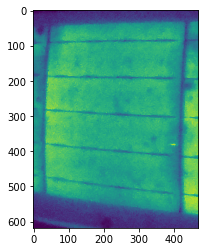

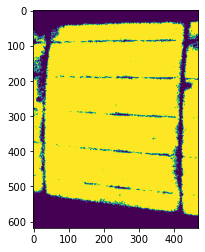

eps=0.0010, num_pts=189


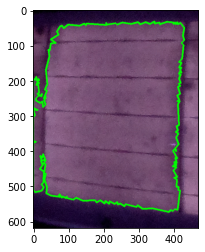

eps=0.0064, num_pts=8


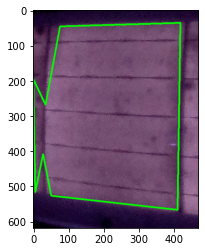

eps=0.0119, num_pts=8


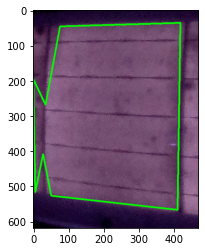

eps=0.0173, num_pts=6


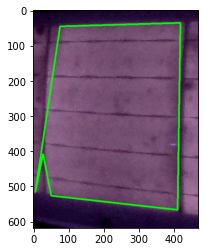

eps=0.0228, num_pts=6


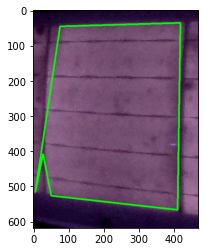

eps=0.0282, num_pts=4


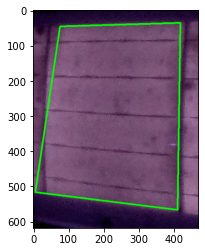

eps=0.0337, num_pts=4


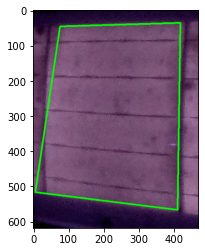

eps=0.0391, num_pts=4


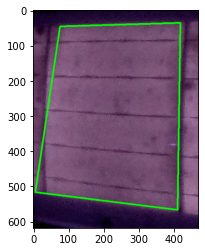

eps=0.0446, num_pts=4


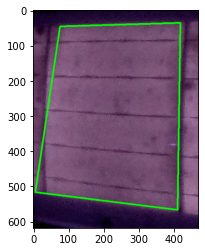

eps=0.0500, num_pts=4


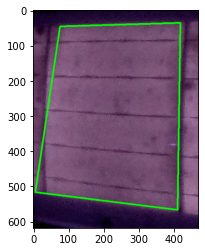

In [74]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('el1_image.jpeg')
original = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()
thresh = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh)
plt.show()

ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.approxPolyDP(cnt,0.3*cv2.arcLength(cnt,True),True)
    #print(len(approx))
    if len(approx)==5:
        #print("Blue = pentagon")
        cv2.drawContours(img,[cnt],0,255,-1)
    elif len(approx)==3:
        #print("Green = triangle")
        cv2.drawContours(img,[cnt],0,(0,255,0),-1)
    elif len(approx)==4:
        #print("Red = square")
        cv2.drawContours(img,[cnt],0,(0,0,255),-1)
    elif len(approx) == 6:
        #print("Cyan = Hexa")
        cv2.drawContours(img,[cnt],0,(255,255,0),-1)
    elif len(approx) == 8:
        #print("White = Octa")
        cv2.drawContours(img,[cnt],0,(255,255,255),-1)
    elif len(approx) > 12:
        #print("Yellow = circle")
        cv2.drawContours(img,[cnt],0,(0,255,255),-1)

for i, c in enumerate(cnts):
    approx = cv2.approxPolyDP(c,0.02*cv2.arcLength(c,True),True)
    areaContour=cv2.contourArea(approx)
    if areaContour<30000 or 2000000<areaContour:
        continue
    #cv2.drawContours(img,cnts,i,(255,10,255),4)        
        
    # to demonstrate the impact of contour approximation, let's loop
    # over a number of epsilon sizes
    for eps in np.linspace(0.001, 0.05, 10):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, eps * peri, True)
        # draw the approximated contour on the image
        output = img.copy()
        cv2.drawContours(output, [approx], -1, (0, 255, 0), 3)
        text = "eps={:.4f}, num_pts={}".format(eps, len(approx))
        print(text)
        plt.imshow(output)
        plt.show()

#cv2.imshow('image', img)
#cv2.imshow('Binary',thresh)
#cv2.waitKey()
#plt.imshow(img)
#plt.show()

In [243]:
import pvimage as pvi
import glob2
from os import chdir
import os
import cv2
from matplotlib import pyplot as plt
wd=os.path.dirname(__file__)
chdir(wd)

ELfolder_path = '../data/Minimodules/*EL*'
ELfiles = glob2.glob(ELfolder_path)
save_path = '../data/out/'

#Extracting individual cells, saving each, and stitching into a combined image
for file in ELfiles:
    try:
        pvi.pipelines.MMpipeline(file,save_path,2,2,True)
    except OverflowError:
        pvi.pipelines.MMpipeline(file,save_path,2,2,True,'lowcon')

PLfile = '../data/Minimodules/MMPL.tiff'
pvi.pipelines.MMpipeline(PLfile,save_path,2,2,True,'lowcon')

saved = glob2.glob('../data/out/*')
for im in saved:
    plt.imshow(cv2.imread(im))
    plt.show()

#Demonstrating the pipeline
img = cv2.imread(PLfile)
plt.imshow(img)
plt.show()

mask = pvi.process.Mask(img, 'lowcon')
plt.imshow(mask)
plt.show()

cells = pvi.process.CellExtract(img, 2, 2)

for cell in cells:
    plt.imshow(cell)
    plt.show()
    plt.imshow(pvi.process.Mask(cell,'lowcon'))
    plt.show()

planarindexed = []
for cell in cells:
    planarindexed.append(pvi.process.PlanarIndex(cell,'lowcon'))

for cell in planarindexed:
    plt.imshow(cell)
    plt.show()

NameError: name '__file__' is not defined